# Stock Market Detection Wyckoff 

In [1]:
from cassandra.cluster import Cluster
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# 1️⃣ ดึงข้อมูลจาก Cassandra

In [2]:
def get_candlestick_data(symbol: str, limit: int = 500):
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
        query = """
            SELECT time, open_price, high_price, low_price, close_price, volume
            FROM candlestick_data
            WHERE symbol = %s
            ORDER BY time DESC
            LIMIT %s
        """
        rows = session.execute(query, (symbol, limit))
        df = pd.DataFrame(list(rows))
        if df.empty:
            print(f"No data for symbol '{symbol}'")
            return pd.DataFrame()
        df.rename(columns={'open_price':'open','high_price':'high','low_price':'low','close_price':'close'}, inplace=True)
        df.sort_values('time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df
    finally:
        try: cluster.shutdown()
        except: pass

# 2️⃣ สร้างฟีเจอร์เชิง Wyckoff Heuristic

In [3]:
def wyckoff_heuristic(df: pd.DataFrame, window=20):
    df = df.copy()
    
    # Moving averages
    df['ma_20'] = df['close'].rolling(window).mean()
    df['ma_50'] = df['close'].rolling(50).mean()
    df['volume_ma_20'] = df['volume'].rolling(window).mean()

    # จุด local min/max
    df['local_min'] = df['low'][(df['low'] == df['low'].rolling(window, center=True).min())]
    df['local_max'] = df['high'][(df['high'] == df['high'].rolling(window, center=True).max())]

    # Wyckoff points heuristic
    df['SC'] = ((df['local_min'].notnull()) & (df['volume'] > df['volume_ma_20']*1.5)).astype(int)
    df['AR'] = ((df['local_max'].notnull()) & (df['volume'] > df['volume_ma_20']*1.2)).astype(int)
    df['Spring'] = ((df['SC'].shift(5) == 1) & (df['close'] > df['ma_20'])).astype(int)

    # โซน Accumulation / Distribution
    df['zone'] = np.where(df['close'] > df['ma_20'], 'Distribution', 'Accumulation')

    df.fillna(0, inplace=True)
    return df

# 3️⃣ Visualization

In [4]:
def plot_wyckoff(df: pd.DataFrame, symbol: str):
    plt.figure(figsize=(15, 7))
    plt.plot(df['time'], df['close'], label='Close Price', linewidth=1.5)

    # Accumulation / Distribution zones
    plt.fill_between(df['time'], df['close'].min(), df['close'].max(),
                     where=(df['zone']=='Accumulation'),
                     color='green', alpha=0.1, label='Accumulation Zone')
    plt.fill_between(df['time'], df['close'].min(), df['close'].max(),
                     where=(df['zone']=='Distribution'),
                     color='red', alpha=0.1, label='Distribution Zone')

    # จุดสำคัญ Wyckoff
    plt.scatter(df.loc[df['SC']==1,'time'], df.loc[df['SC']==1,'close'], color='blue', marker='v', s=60, label='SC')
    plt.scatter(df.loc[df['AR']==1,'time'], df.loc[df['AR']==1,'close'], color='orange', marker='^', s=60, label='AR')
    plt.scatter(df.loc[df['Spring']==1,'time'], df.loc[df['Spring']==1,'close'], color='purple', marker='*', s=100, label='Spring')

    plt.title(f"Wyckoff Heuristic Zones - {symbol}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.legend()
    plt.show()

# 4️⃣ MAIN PIPELINE

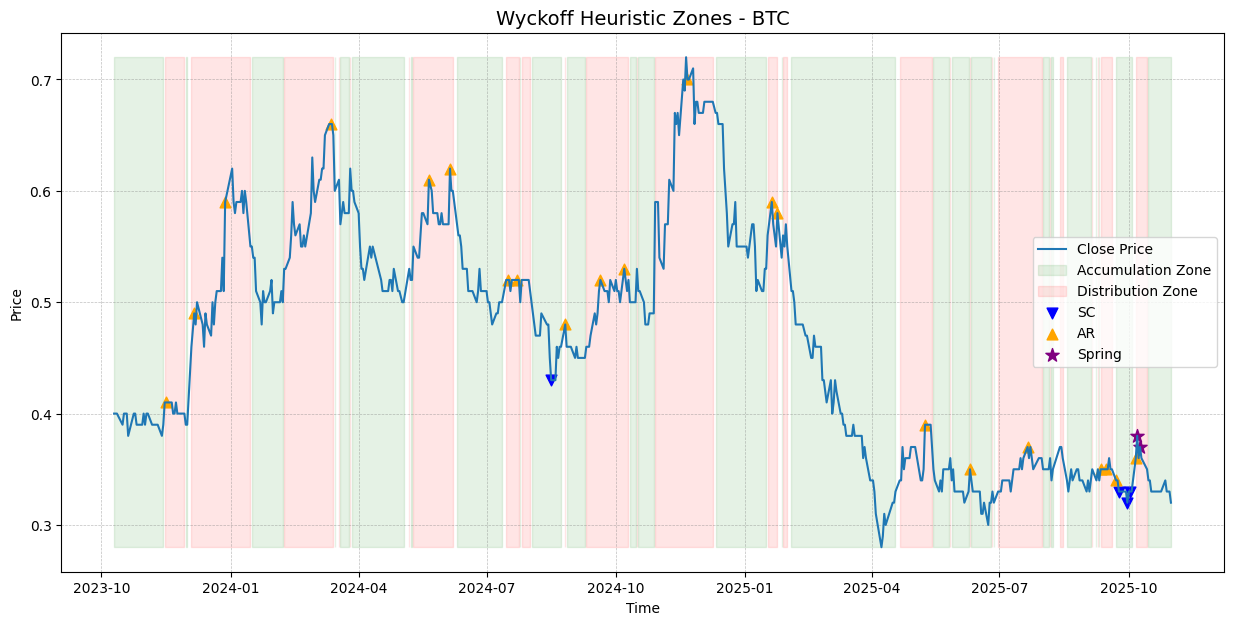

In [5]:
if __name__ == "__main__":
    symbol = "BTC"
    df = get_candlestick_data(symbol, limit=500)
    if not df.empty:
        df = wyckoff_heuristic(df)
        plot_wyckoff(df, symbol)
